# 2D simulation with SPECFEM2D
By Andrea R. using utility functions written by Ridvan Orsvuran

In [1]:
import os
import numpy as np
from scipy.integrate import simps
import matplotlib.pyplot as plt
import obspy
import re
import IPython.display as dp
from PIL import Image

In [2]:
# Some utility functions (written by Ridvan Orsvuran)
def read_trace(filename):
    """Reads an ASCII file and returns a obspy Traces"""
    data = np.loadtxt(filename)
    # first column is time, second column is the data
    times = data[:, 0]
    disp = data[:, 1]
    # get station name from the filename
    net, sta, comp, *_ = filename.split("/")[-1].split(".")
    delta = times[1] - times[0]
    headers = {"station": sta, "network": net, "channel": comp, "delta": delta, "b": times[0]}
    return obspy.Trace(disp, headers)

def save_trace(tr, filename):
    """Writes out the traces as an ASCII file. Uses b value as the beginning."""
    data = np.zeros((len(tr.data), 2))
    data[:, 0] = tr.times()+tr.stats.b
    data[:, 1] = tr.data
    np.savetxt(filename, data)
       
def specfem_write_parameters(filename, parameters, output_file=None):
    """Write parameters to a specfem config file"""

    with open(filename) as f:
        pars = f.read()

    for varname, value in parameters.items():
        pat = re.compile(
            r"(^{varname}\s*=\s*)([^#$\s]+)".format(varname=varname),
            re.MULTILINE)
        pars = pat.sub(r"\g<1>{value}".format(value=value), pars)

    if output_file is None:
        output_file = filename

    with open(output_file, "w") as f:
        f.write(pars)     
        
def specfem2D_prep_save_forward(filename=None):
    if filename is None:
        filename = "./DATA/Par_file"
    params = {
        "SIMULATION_TYPE": 1,
        "SAVE_FORWARD": ".true."
    }
    specfem_write_parameters(filename, params)
    
def specfem2D_prep_adjoint(filename=None):
    if filename is None:
        filename = "./DATA/Par_file"
    params = {
        "SIMULATION_TYPE": 3,
        "SAVE_FORWARD": ".false."
    }
    specfem_write_parameters(filename, params)
      
def grid(x, y, z, resX=100, resY=100):
    """
    Converts 3 column data to matplotlib grid
    """
    # Can be found in ./utils/Visualization/plot_kernel.py
    from scipy.interpolate import griddata

    xi = np.linspace(min(x), max(x), resX)
    yi = np.linspace(min(y), max(y), resY)

    # mlab version
    #Z = griddata(x, y, z, xi, yi, interp='linear')
    # scipy version
    Z = griddata((x, y), z, (xi[None,:], yi[:,None]), method='cubic')

    X, Y = np.meshgrid(xi, yi)
    return X, Y, Z

### Domain: 
2D:   
x-dir = 4000 m   
z-dir = 4000 m   

### Source location
original x:    1000 m     
original z:    2000 m  

### Output station location: 
Station #1   AAS0001                             
original x:    3000 m  
original z:    2000 m  

### Boundary conditions 
Type: STACEY_ABSORBING_CONDITIONS  
absorbbottom                    = true  
absorbright                     = true  
absorbtop                       = true  
absorbleft                      = true  

### Velocity model:

Model: P (or PI) velocity min,max =    3000 m/s              
Model: S velocity min,max         =    1800 m/s        
Model: density min,max            =    2700 kg/m3           

### To reproduce this example copy the files in DATA to the specfem2d directory: specfem2d/DATA

### Set Specfem2D directory path

In [3]:
specfem2d_path = "/Users/andreacamilarianoescandon/packages/specfem2d"

### 1. Run the mesher

In [4]:
os.chdir(specfem2d_path)
!$specfem2d_path/bin/xmeshfem2D


 **********************************************
 *** Specfem 2-D Mesher - serial version    ***
 **********************************************

 Running Git version of the code corresponding to 
 dating From 

 Reading the parameter file...

 Title of the simulation: Test of SPECFEM2D with curved interfaces


 Receiver lines:
   Nb of line sets =            2

   using existing STATIONS file: ./DATA/STATIONS
   file name is ./DATA/STATIONS
   found            4  receivers

 Materials:
   Nb of solid, fluid or porous materials =            4

 --------
 Material #           1  isotropic
 rho,cp,cs   =    2700.0000000000000        3000.0000000000000        1800.0000000000000     
 Qkappa, Qmu =    9999.0000000000000        9999.0000000000000     
 Material is solid
 --------
 Material #           2  isotropic
 rho,cp,cs   =    2500.0000000000000        2700.0000000000000        0.0000000000000000     
 Qkappa, Qmu =    9999.0000000000000        9999.0000000000000     
 Material is flui

### 2. Run the solver

In [5]:
!$specfem2d_path/bin/xspecfem2D


 **********************************************
 **** Specfem 2-D Solver - serial version  ****
 **********************************************

 Running Git version of the code corresponding to 
 dating From 


 NDIM =            2

 NGLLX =            5
 NGLLZ =            5

 using single precision for the calculations

 smallest and largest possible floating-point numbers are:    1.17549435E-38   3.40282347E+38

 Reading the parameter file...

 Title of the simulation: Test of SPECFEM2D with curved interfaces


   using existing STATIONS file: ./DATA/STATIONS
   file name is ./DATA/STATIONS
   found            4  receivers

 Parameter file successfully read 

 Reading in SOURCE file...

 Source           1
   Position xs, zs =    1000.0000000000000        2000.0000000000000     

   Source type (1=force, 2=moment tensor):            1
   Force source:
   Angle of the source (deg) =    0.0000000000000000     

   Time function type (1=Ricker, 2=First derivative, 3=Gaussian, 4=Dirac

 Mesh dimensions:
   Xmin,Xmax of the whole mesh =    0.0000000000000000        4000.0000000000005     
   Zmin,Zmax of the whole mesh =    0.0000000000000000        4000.0000000000005     

 Material properties:
   MODEL                 : default
   nspec                 :         6400
   assign external model :  F

   setting up material arrays
   all material arrays done

 Domains:
   total number of acoustic elements        =            0
   total number of elastic elements         =         6400
   total number of poroelastic elements     =            0

 Setting up MPI communication arrays

   maximum number of MPI interfaces (for a single slice) =            0

   This is a single process simulation, no need for MPI communication

   number of outer elements  =            0
   number of inner elements  =         6400

   percentage of outer elements    0.00000000     %
   percentage of inner elements    100.000000     %

   number of global nodes in outer elements  =            


 ******************************************************************
Time step number     100   t =    0.1089 s out of    1600
 ******************************************************************
 We have done    6.19136953     % of the total
 Max norm of vector field in solid (elastic) =   0.233192295    
 Elapsed time in seconds =   0.23099994659423828     
 Elapsed time in hh:mm:ss =      0 h 00 m 00 s
 Mean elapsed time per time step in seconds =    2.3099994659423828E-003
 Time steps remaining =         1500
 Estimated remaining time in seconds =    3.4649991989135742     
 Estimated remaining time in hh:mm:ss =      0 h 00 m 03 s
 Estimated total run time in seconds =    3.6959991455078125     
 Estimated total run time in hh:mm:ss =      0 h 00 m 03 s
 The run will finish approximately on: Thu Feb 09, 2023 18:09

 Creating color image of size          762  x          800  for time step          100
 drawing scalar image of the forward wavefield displacement...
 Color image maximu


 ******************************************************************
Time step number     900   t =    0.9889 s out of    1600
 ******************************************************************
 We have done    56.2226410     % of the total
 Max norm of vector field in solid (elastic) =    3.36416513E-02
 Elapsed time in seconds =    2.1339998245239258     
 Elapsed time in hh:mm:ss =      0 h 00 m 02 s
 Mean elapsed time per time step in seconds =    2.3711109161376953E-003
 Time steps remaining =          700
 Estimated remaining time in seconds =    1.6597776412963867     
 Estimated remaining time in hh:mm:ss =      0 h 00 m 01 s
 Estimated total run time in seconds =    3.7937774658203125     
 Estimated total run time in hh:mm:ss =      0 h 00 m 03 s
 The run will finish approximately on: Thu Feb 09, 2023 18:09

 Creating color image of size          762  x          800  for time step          900
 drawing scalar image of the forward wavefield displacement...
 Color image maximu

### 3. Plot synthetic seismogram

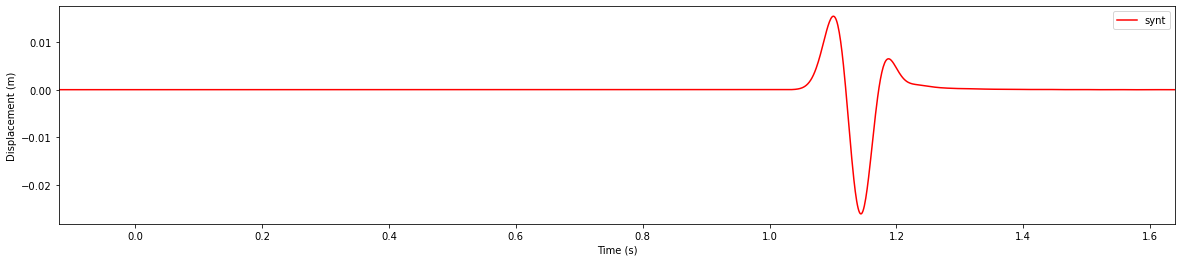

In [6]:
# Read synthetic seismogram
synt = read_trace("./OUTPUT_FILES/AA.S0001.BXY.semd")

# Process data
synt.detrend("simple")
synt.taper(0.05)
synt.filter("bandpass", freqmin=0.01, freqmax=20)

fig, ax = plt.subplots(figsize=(20, 4))
# Use the beginning time value from the file: tr.times()+tr.stats.b
ax.plot(synt.times()+synt.stats.b, synt.data, "r", label="synt")
ax.set_xlim(synt.stats.b, synt.times()[-1]+synt.stats.b)
ax.legend()
ax.set_xlabel("Time (s)");
ax.set_ylabel("Displacement (m)");

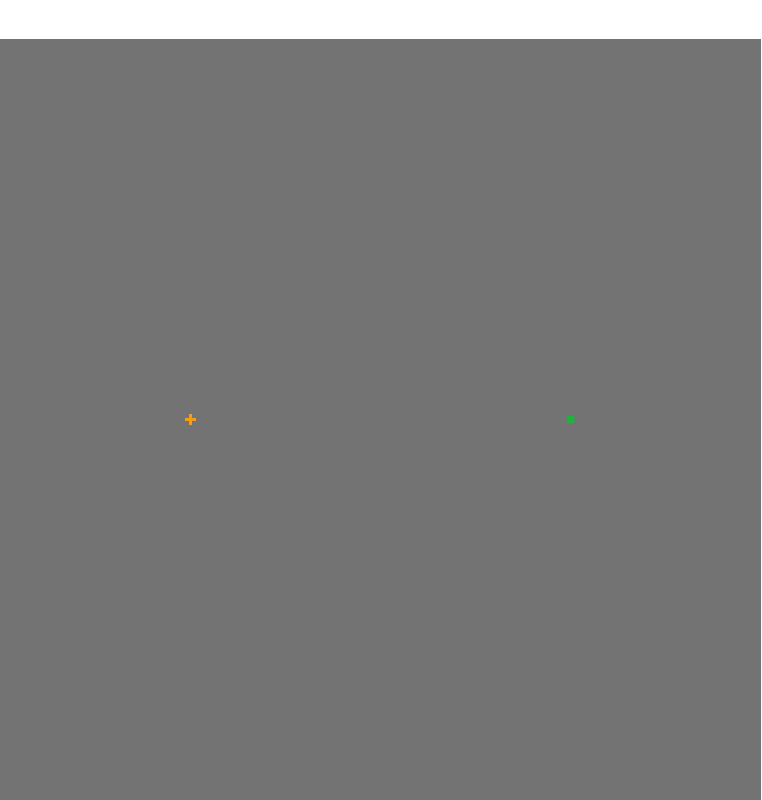

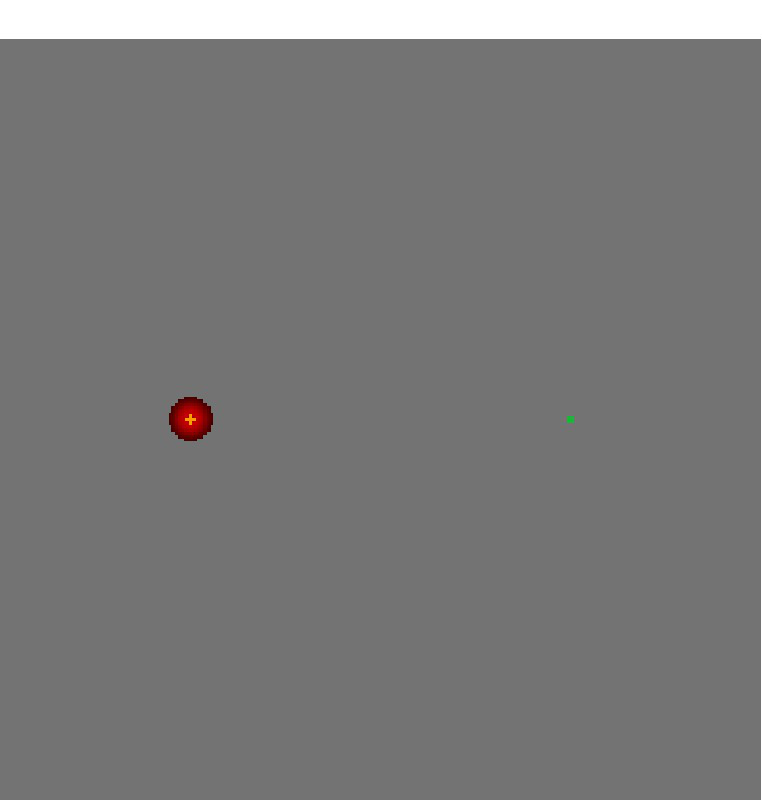

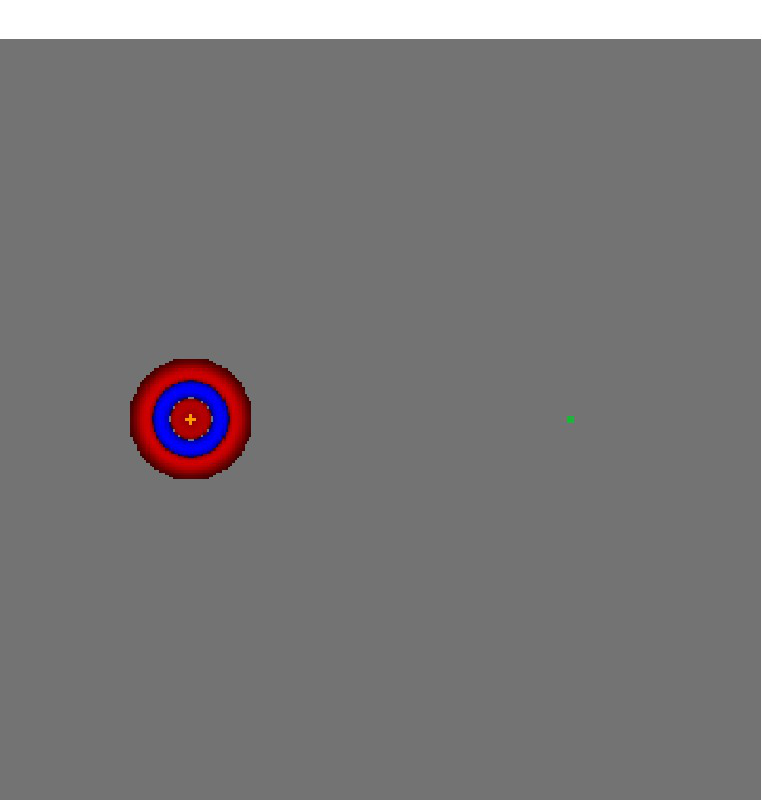

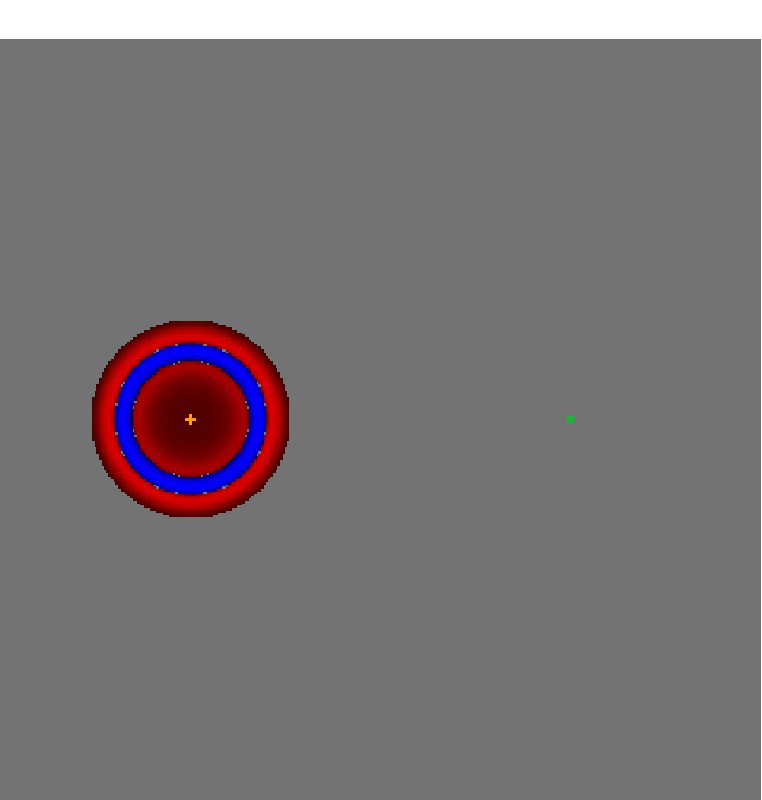

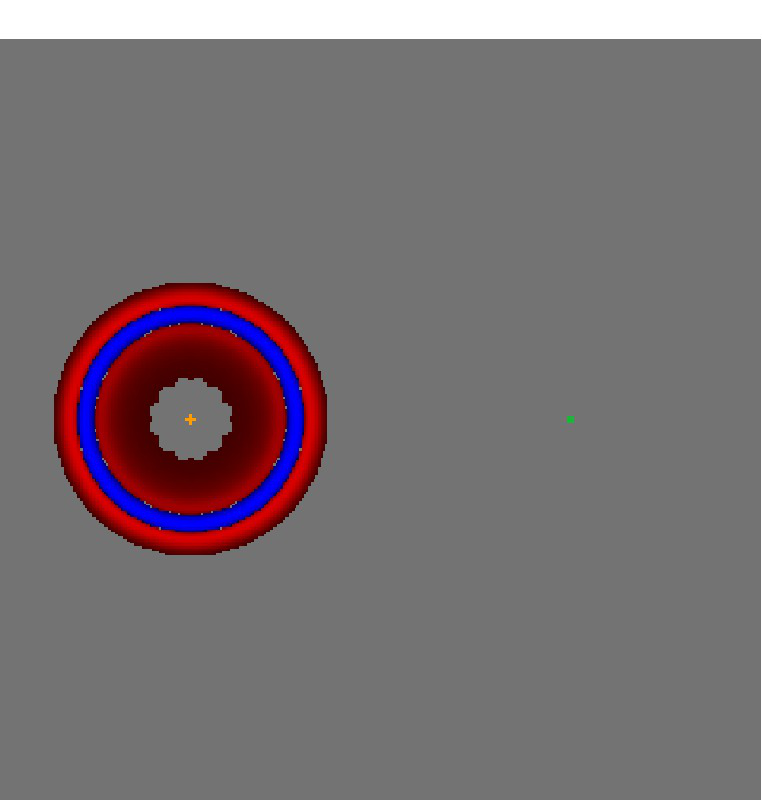

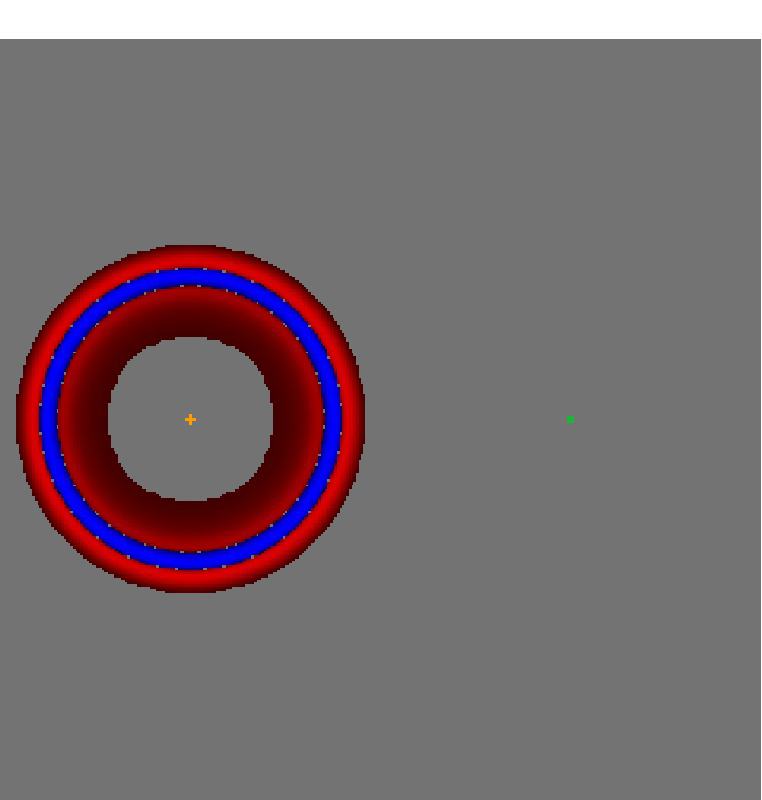

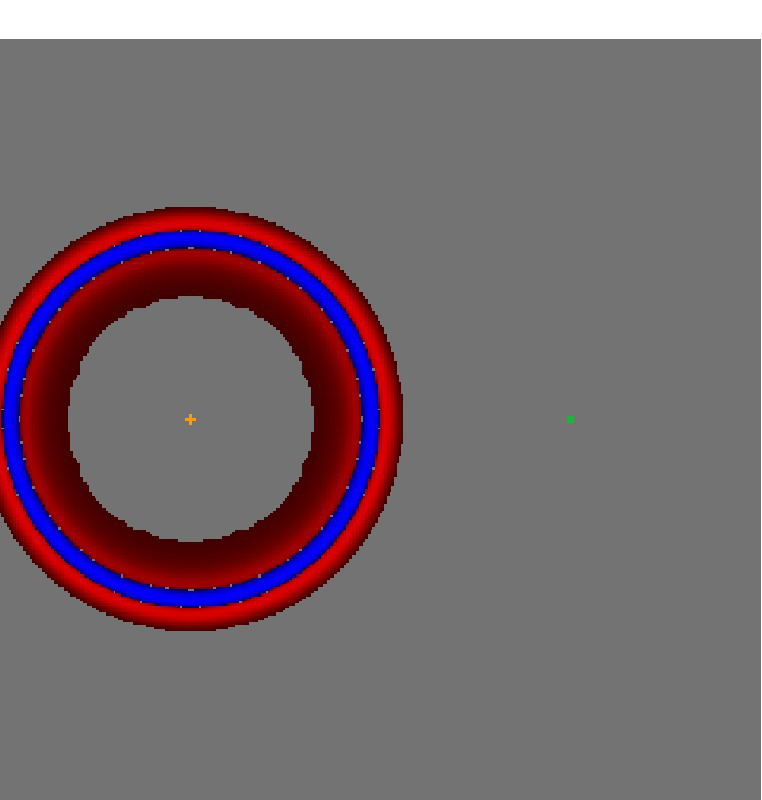

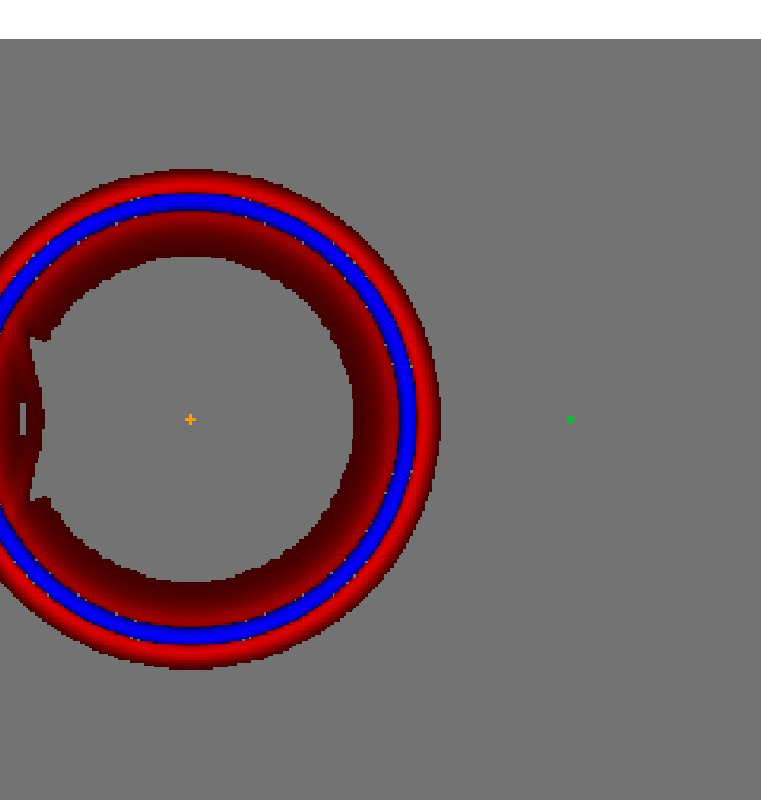

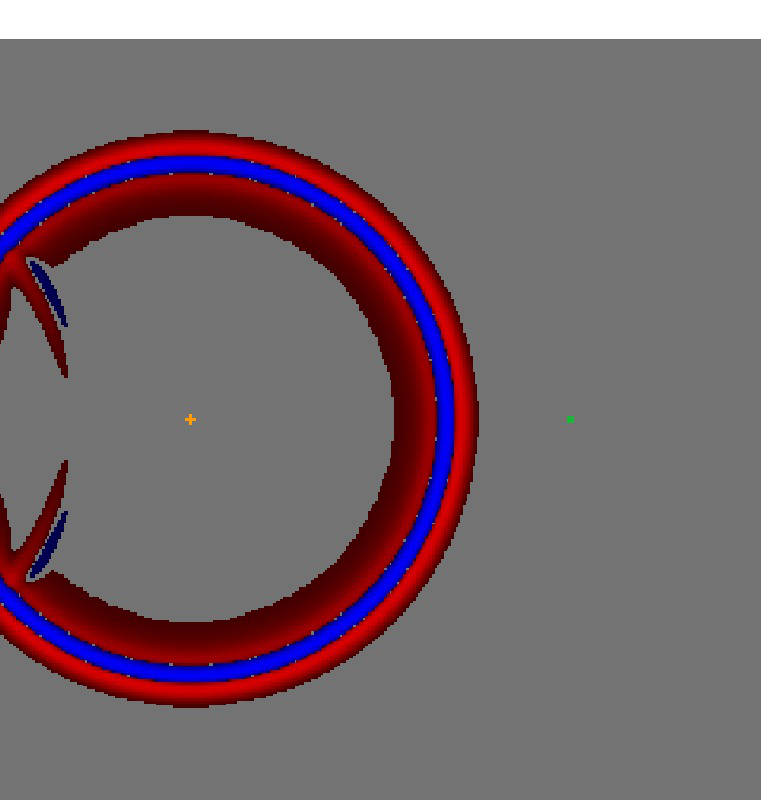

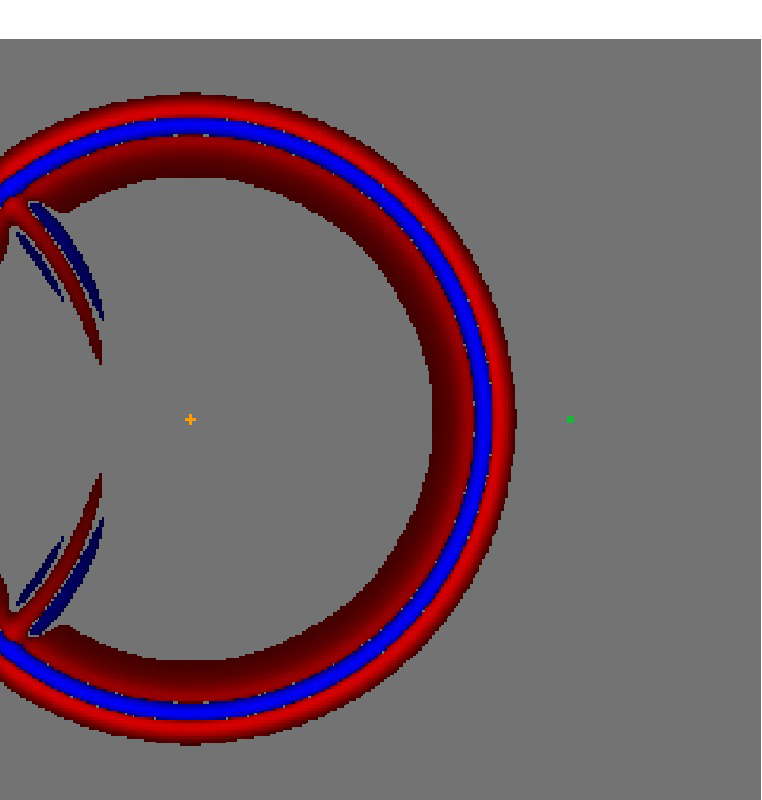

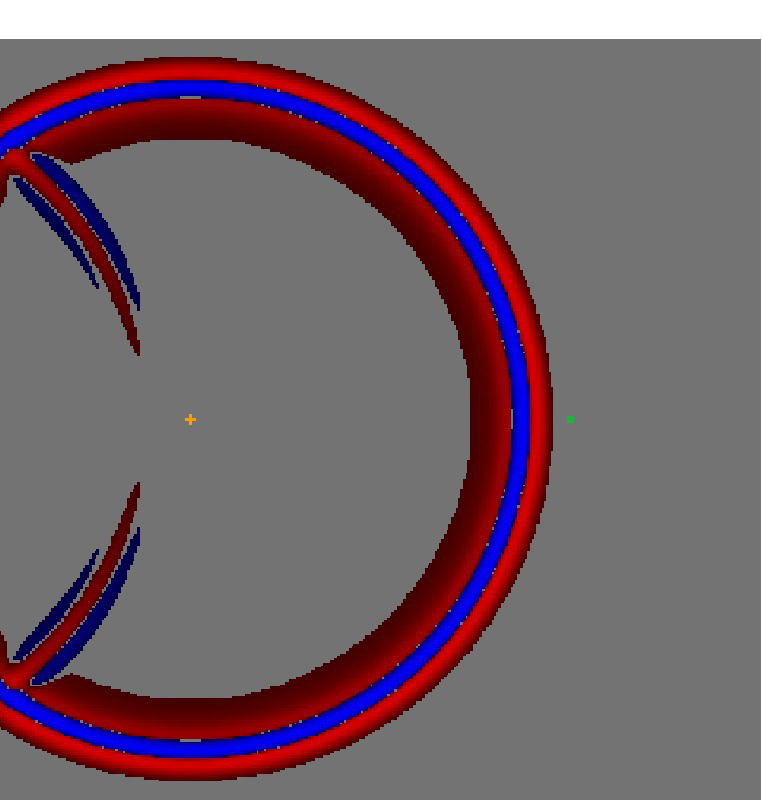

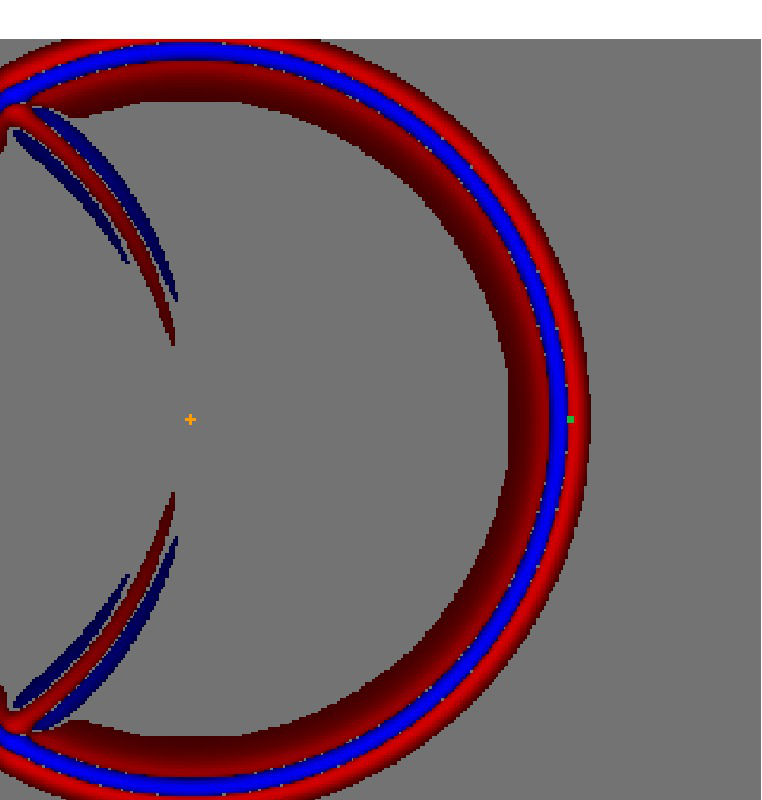

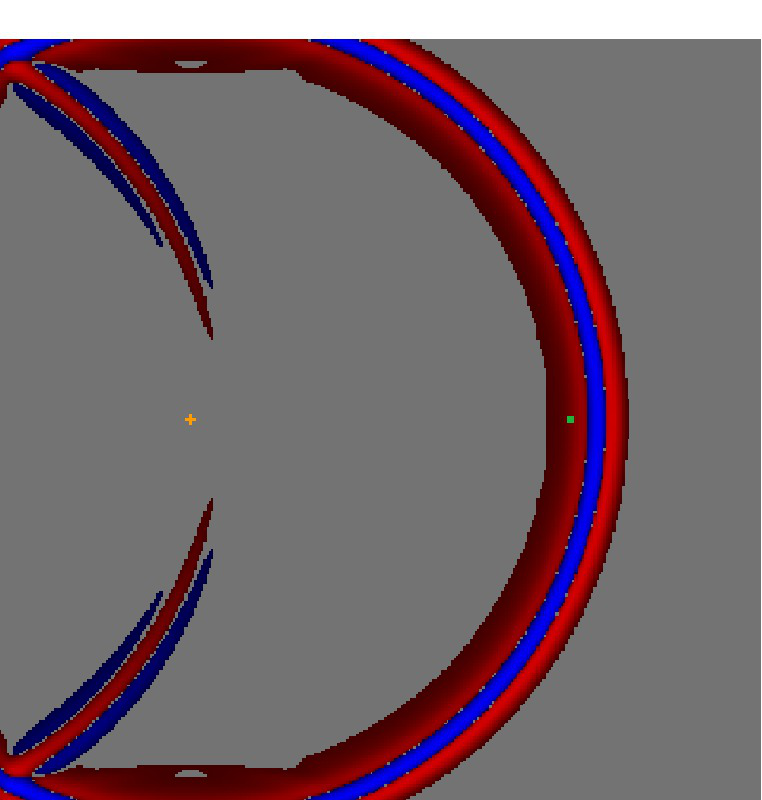

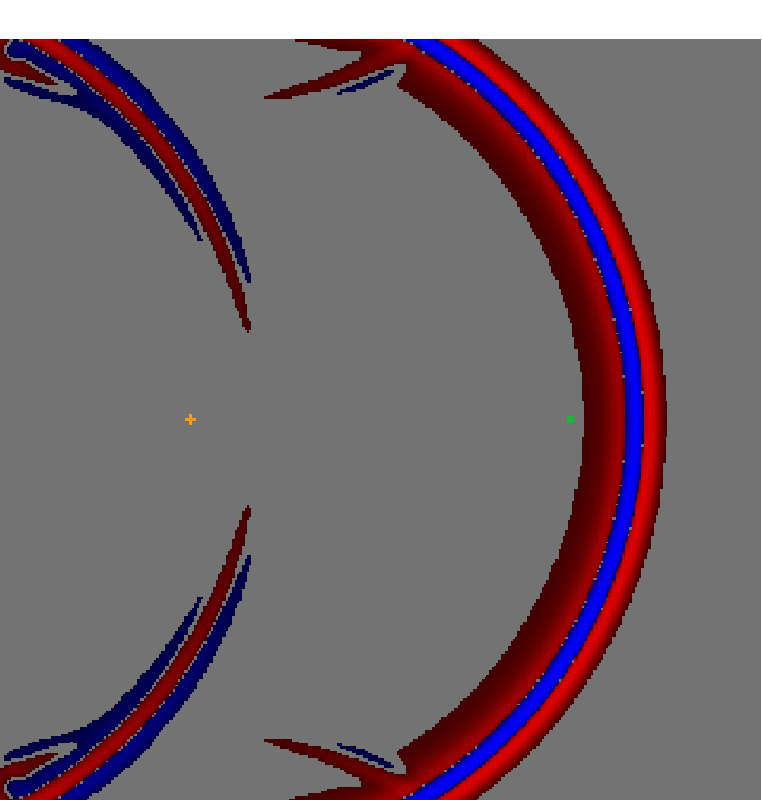

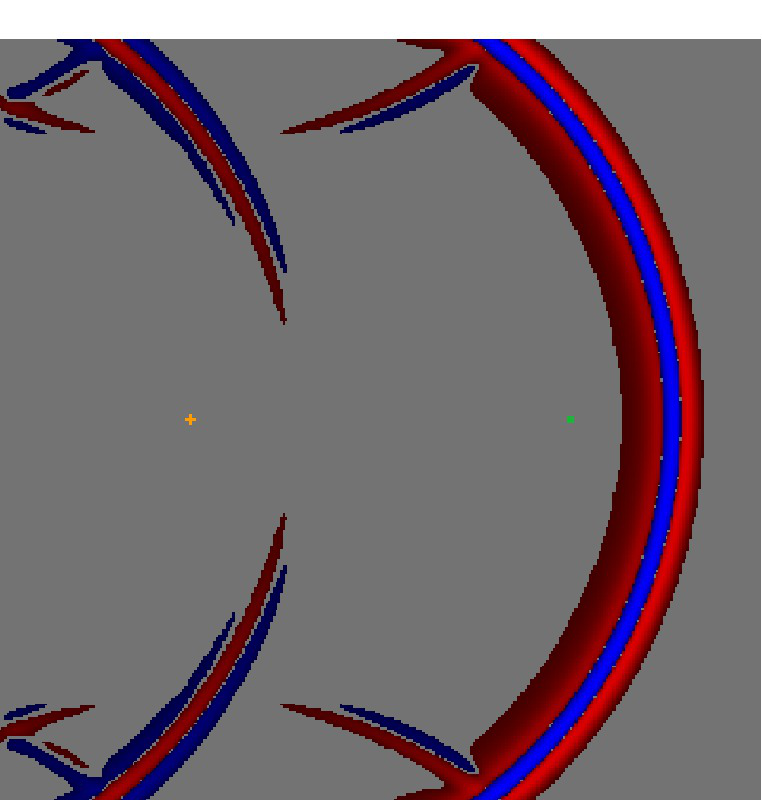

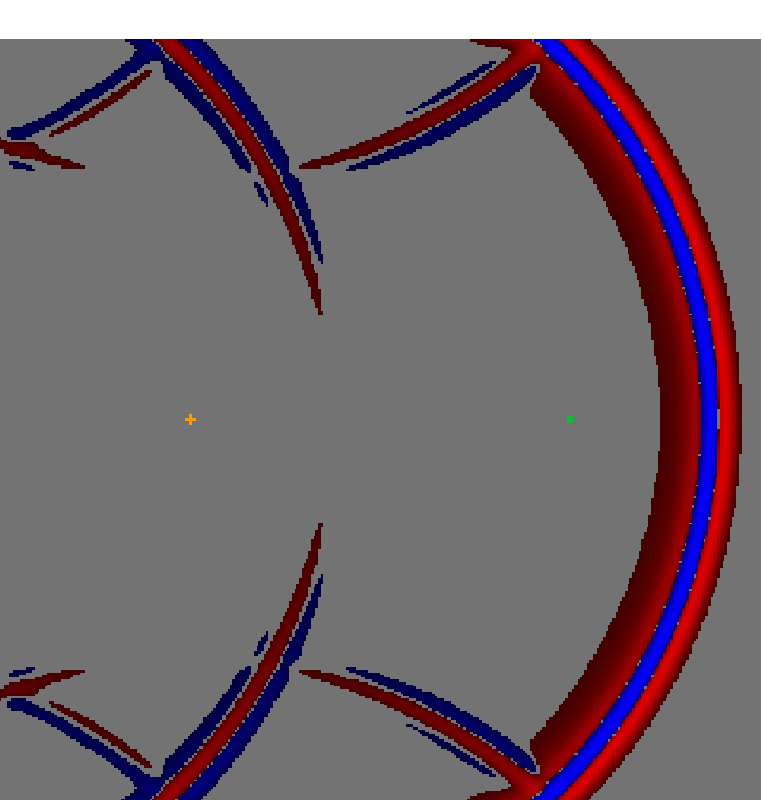

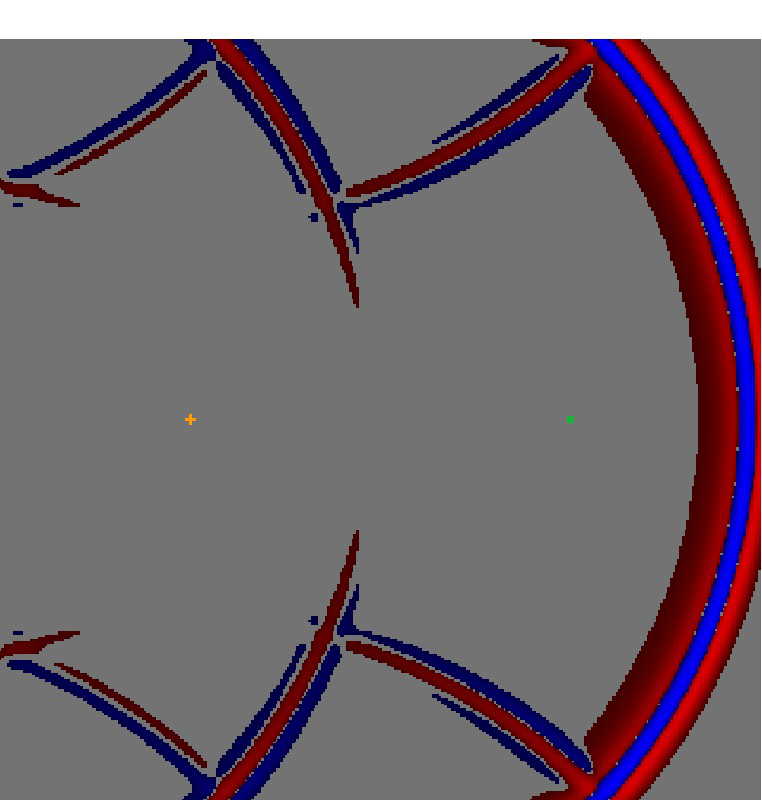

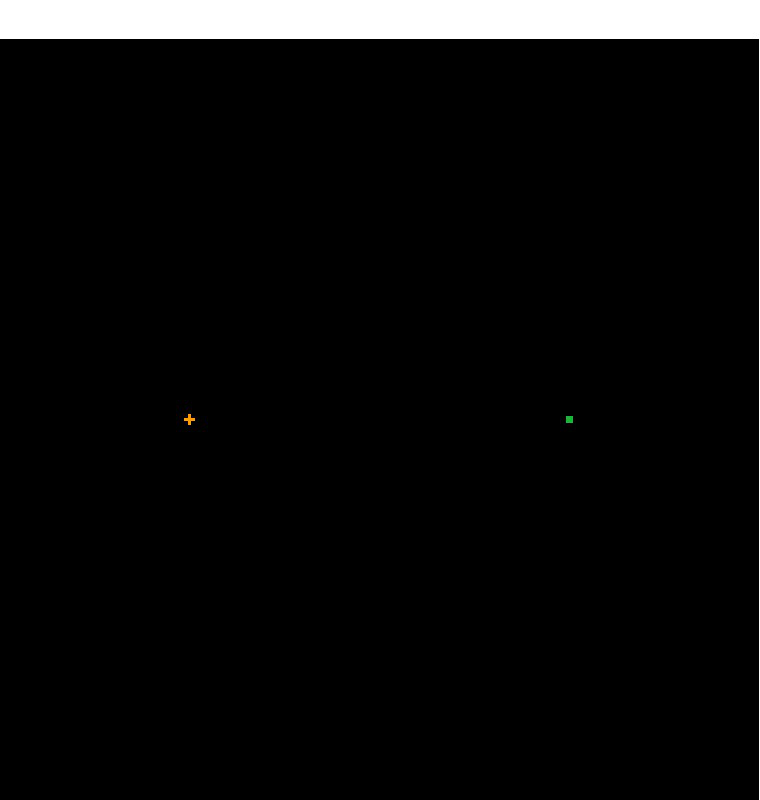

In [7]:
### 4. Snapshots 
images=[]
# collect all .jpg files in OUTPUT_FILES directory
fs = !ls OUTPUT_FILES/*.jpg
# Print .jpg files
for ea in fs:
    images.append(dp.Image(filename=ea,format='jpg'))
for ea in fs:
    dp.display(Image.open(ea))